In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from models.nets import MLP

In [2]:
class VAE(nn.Module):
    def __init__(self, features, encoding_dim=32):
        super().__init__()
        self.encoding_dim = encoding_dim
        self.features = features
        self.encoder = MLP.MLP(features, encoding_dim*2)
        self.decoder = MLP.MLP(encoding_dim, features)
    
    def get_latent_representation(self, x):
        x_latent = self.encoder(x.view(x.size(0), -1))
        return x_latent[:, :self.encoding_dim], F.softplus(x_latent[:, self.encoding_dim:])
    
    def encode(self, x):
        mu, std = self.get_latent_representation(x)
        return mu + torch.randn(self.encoding_dim, device="cuda")*std

    def decode(self, x):
        return torch.sigmoid(self.decoder(x).view(x.size(0), 1, 28, 28))

    def forward(self, x):
        return self.decode(self.encode(x))

In [3]:
def train_step(model, data, target, optimizer, criterion):
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    loss.backward()
    optimizer.step()

    return loss.item()

def train_epoch(model, train_loader, criterion, device, optimizer, scheduler=None):
    model.train()
    losses = []
    for data, _ in train_loader:
        data = data.float().to(device)
        target = data.clone()
        loss = train_step(model, data, target, optimizer, criterion)
        losses.append(loss)
        if scheduler is not None:
            scheduler.step()

    return losses


def eval_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    count = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.float().to(device)
            target = data.clone()
            output = model(data)
            test_loss += criterion(output, target).item() * data.shape[0]
            count += data.shape[0]

    test_loss /= len(test_loader.dataset)
    return test_loss

In [4]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=1024, shuffle=True, num_workers=3)

In [18]:
device = torch.device("cuda")
vae = VAE(784, 128).to(device)

In [22]:
# Train the VAE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(10):
    train_epoch(vae, train_loader, criterion, device, optimizer)
    test_loss = eval_epoch(vae, train_loader, criterion, device)
    print(f"Epoch {epoch}: test loss {test_loss}")

Epoch 0: test loss 0.0077726124626894795
Epoch 1: test loss 0.006948877049982548
Epoch 2: test loss 0.006752351484944423
Epoch 3: test loss 0.006308183635771274
Epoch 4: test loss 0.0060870139663418135
Epoch 5: test loss 0.005702375895529985
Epoch 6: test loss 0.00565758067642649
Epoch 7: test loss 0.005678282635162274
Epoch 8: test loss 0.005631430512915055
Epoch 9: test loss 0.0054244175230463345


In [31]:
# shows the vae performance
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        y = vae(x)
        break

In [7]:
from einops import rearrange

In [59]:
with torch.no_grad():
    y = vae(x)

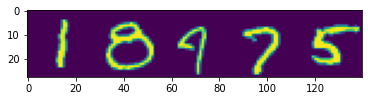

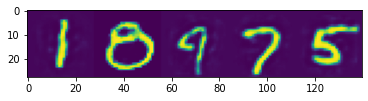

In [60]:
import pylab as pl
pl.imshow(rearrange(x[:5], 'b c h w -> h (b c w)').detach().cpu())
pl.show()
pl.imshow(rearrange(y[:5], 'b c h w -> h (b c w)').detach().cpu())